# Embedding Optimization
We will apply embedding optimization techniques to improve the quality of our embeddings for better recommendation performance. While creating the model we had a lot of options to choose from. Here we will explore some of those options and see how they affect the model performance.

In [121]:
from helpers.notebook_pipelines.yes_tuned_bow_model import run_evaluation_multi
from sentence_transformers import SentenceTransformer, util
from sklearn.feature_extraction.text import TfidfVectorizer
from helpers.functs.StudentProfile import StudentProfile
from sklearn.metrics.pairwise import cosine_similarity
from typing import Iterable, Set, Tuple, List
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import torch
import time
import ast

In [122]:
# Our mocked student profiles
student1 = StudentProfile(
    current_study= "Kunst & Onderzoek",
    interests=[
        "Tekenen",
        "Animatie",
        "Kunst",
        "Drama",
        "Ik hou ervan om mensen te vermaken. Dit doe ik het liefst door bijvoorbeeld te dansen, te zingen of toneelspelen. In het algemeen vind ik het fijn om creatief bezig te zijn. Ik ben graag onder de mensen."
    ],
    wanted_study_credit_range=(15, 30),
    location_preference=["Den Bosch", "Breda", "Tilburg"],
    learning_goals=["Kritisch denken", "Sociale vaardigheden", "Zelfverzekerdheid", "Ik wil o.a. leren hoe ik betere illustraties kan maken zowel analoog als digitaal."],
    level_preference=["NLQF5", "NLQF6"],
    preferred_language="NL",
    preferred_start_range="any"
)
student2 = StudentProfile(
    current_study= "Informatica",
    interests=[
        "Programmeren",
        "AI",
        "Coderen",
        "Techniek",
        "Software",
        "Ik heb werken met computers en techniek van jongs af aan al interessant gevonden. Kunstmatige intelligentie is nu ook zeker iets dat me interesseert, zeker met de sterke opkomst hiervan. Zo kun je denken aan machine learning, deep learning, etc. Ik wil me vooral bezighouden met software."
    ],
    wanted_study_credit_range=(15, 30),
    location_preference=["Den Bosch", "Breda", "Tilburg"],
    learning_goals=["Kritisch denken", "Technische Vaardigheden", "Eén van de dingen die ik wil leren is het toepassen van mijn kennis in de praktijk"],
    level_preference=["NLQF5", "NLQF6"],
    preferred_language="NL",
    preferred_start_range="any"
)
student3 = StudentProfile(
    current_study= "Psychologie",
    interests=[
        "Mensen",
        "Emoties",
        "Gedrag",
        "Psychologie",
        "Ik wil graag weten waarom mensen bepaalde dingen doen; ik wil mensen hun gedrag kunnen begrijpen. Naast hun gedrag wil ik ook leren over, persoonlijkheden en emoties. Graag wil ik mensen hun welzijn kunnen bevorderen met het gebruik van psychologische kennis."
    ],
    wanted_study_credit_range=(15, 30),
    location_preference=["Den Bosch", "Breda", "Tilburg"],
    learning_goals=["Kritisch denken", "Sociale Vaardigheden", "Ik wil leren hoe ik mensen en hun gedrag beter kan analyseren"],
    level_preference=["NLQF5", "NLQF6"],
    preferred_language="NL",
    preferred_start_range="any"
)

student4 = StudentProfile(
    current_study="Economics",
    interests=[
        "Business",
        "Entrepreneurship",
        "Strategies",
        "Branding",
        "I am a real entrepreneur. I am especially interested in how innovation, strategy, and future developments influence economic growth and organizational success"
    ],
    wanted_study_credit_range=(15, 30),
    location_preference=["Den Bosch", "Breda", "Tilburg"],
    learning_goals=["Forward thinking", "Social skill", "I want to better understand the impact of modern technologies on business models"],
    level_preference=["NLQF5", "NLQF6"],
    preferred_language="NL",
    preferred_start_range="any"
)

student5 = StudentProfile(
    current_study="Verpleegkunde, Mens en Techniek",
    interests=[
        "Zorg",
        "Gezondheid",
        "Medisch",
        "Verpleegkunde",
        "Ik ben erg geïnteresseerd in verpleegkunde en hoop ook later in een ziekenhuis omgeving te kunnen werken. Daarom wil ik ook meer praktische ervaring op doen passend bij mijn studie verpleegkunde met de module die ik kies."
    ],
    wanted_study_credit_range=(15, 30),
    location_preference=["Den Bosch", "Breda", "Tilburg"],
    learning_goals=["Sociale vaardigheden", "Persoonlijke ontwikkeling", "Ik leren hoe ik beter kan anticiperen op bepaalde zorgbehoeften"],
    level_preference=["NLQF5", "NLQF6"],
    preferred_language="NL",
    preferred_start_range="any"
)

students = [student1, student2, student3, student4, student5]

In [123]:
softNLP_df = pd.read_csv("../Data/Cleaned/cleaned_dataset_soft-NLP.csv")
hardNLP_df = pd.read_csv("../Data/Cleaned/cleaned_dataset_hard-NLP.csv")

# safely join selected columns into text (handle NaNs and non-str types)
cols = ['name', 'description', 'learningoutcomes', 'module_tags']

softNLP_module_text = (
    softNLP_df[cols]
    .fillna('')
    .astype(str)
    .agg(' '.join, axis=1)
    .str.replace(r'\s+', ' ', regex=True)
    .tolist()
)
# use the dataset 'id' column so we report the real module ids (not dataframe positional indices)
soft_module_ids = softNLP_df['id'].tolist()

hardNLP_module_text = (
    hardNLP_df[cols]
    .fillna('')
    .astype(str)
    .agg(' '.join, axis=1)
    .str.replace(r'\s+', ' ', regex=True)
    .tolist()
)
hard_module_ids = hardNLP_df['id'].tolist()

# keep texts and their original ids together so we compute top-k per corpus
nlp_options = {
    "soft": (softNLP_module_text, soft_module_ids),
    "hard": (hardNLP_module_text, hard_module_ids)
}

In [124]:
model_options = {
    "Model1": SentenceTransformer("all-MiniLM-L6-v2"),
    "Model2": SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2"),
    "Model3": SentenceTransformer("distiluse-base-multilingual-cased-v2")
}

In [125]:
top_k = 5

## Variations
We will create several variations of our embedding models by changing parameters such as:
- Model architecture
- Preprocessing techniques
- Fine-tuning strategies

In [126]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cpu


In [127]:
# DataFrame to store benchmark info
benchmark_data = []

for s_idx, student in enumerate(students, start=1):
    query_text = student.to_text()
    student_name = f"student{s_idx}"

    for nlp_name, (module_texts, module_ids) in nlp_options.items():
        for model_name, model in model_options.items():
            start_time = time.time()
            # Encode modules
            module_vectors = model.encode(module_texts, convert_to_tensor=True, device=device)
            query_vector = model.encode([query_text], convert_to_tensor=True, device=device)
            scores = util.cos_sim(query_vector, module_vectors)[0].cpu().numpy()
            top_indices = scores.argsort()[::-1][:top_k]
            top_matches = [(module_ids[i], float(scores[i])) for i in top_indices]

            # Compute precision
            gt_key = student_name.lower() if student_name.lower() in ground_truth else student_name
            relevant_set = set(ground_truth.get(gt_key, []))
            precision = precision_at_k(top_matches, top_k, relevant_set)

            end_time = time.time()
            elapsed_time = end_time - start_time

            benchmark_data.append({
                "student": student_name,
                "model": model_name,
                "nlp": nlp_name,
                "precision@5": precision,
                "time_sec": elapsed_time
            })


In [128]:
for student_name, student_results in results.items():
    print(f"\n===== {student_name} =====")
    for nlp_name, nlp_results in student_results.items():
        print(f"\n-- {nlp_name} --")
        for model_name, matches in nlp_results.items():
            print(f"{model_name}: {matches}")


===== Student1 =====

-- soft --
Model1: [(32, 0.6879175901412964), (204, 0.6761541366577148), (205, 0.6016901731491089), (61, 0.6006748676300049), (199, 0.5994069576263428)]
Model2: [(32, 0.7134238481521606), (188, 0.6478080749511719), (201, 0.6065809726715088), (192, 0.6056426763534546), (204, 0.6036763191223145)]
Model3: [(32, 0.5802501440048218), (61, 0.46715906262397766), (204, 0.4508151710033417), (190, 0.440643310546875), (200, 0.3975970149040222)]

-- hard --
Model1: [(205, 0.5892462730407715), (204, 0.5761686563491821), (32, 0.5637335777282715), (206, 0.5525189638137817), (192, 0.5389763116836548)]
Model2: [(202, 0.6092264652252197), (204, 0.5959000587463379), (192, 0.5894416570663452), (199, 0.5555411577224731), (61, 0.5532780885696411)]
Model3: [(32, 0.4434344172477722), (204, 0.4381777346134186), (202, 0.3870798349380493), (190, 0.38502469658851624), (192, 0.3626526892185211)]

===== Student2 =====

-- soft --
Model1: [(146, 0.7170849442481995), (179, 0.6960562467575073), 

## presision@k Evaluation
We will evaluate the performance of each variation using precision@k metric to determine which configuration yields the best results.

In [129]:
# Ground-truth relevant modules per student
ground_truth = {
    "student1": [388, 392, 191, 385, 386, 379, 389, 377, 391, 233],
    "student2": [304, 305, 312, 317, 318, 322, 321, 334, 336, 340, 333],
    "student3": [159, 290, 397, 180, 177, 208, 173, 193, 357],
    "student4": [229, 272, 280, 279, 235, 380],
    "student5": [160, 199, 161, 163]
}

In [130]:
def precision_at_k(top_matches, k, relevant_set):
    """
    top_matches: list of (index, score)
    relevant_set: set of ground truth module indices
    """
    top_indices = [idx for idx, _ in top_matches[:k]]
    relevant_in_top_k = sum(1 for idx in top_indices if idx in relevant_set)
    return relevant_in_top_k / k

# Compute Precision@k for all students
precision_results = {}

for student_name, student_results in results.items():
    precision_results[student_name] = {}
    for nlp_name, module_results in student_results.items():
        precision_results[student_name][nlp_name] = {}
        for model_name, top_matches in module_results.items():
            # ground_truth keys use lowercase (e.g. 'student1') while results use 'Student1'
            gt_key = student_name.lower() if student_name.lower() in ground_truth else student_name
            relevant_set = set(ground_truth.get(gt_key, []))
            precision = precision_at_k(top_matches, top_k, relevant_set)
            precision_results[student_name][nlp_name][model_name] = precision

# Display
for student_name, student_precisions in precision_results.items():
    print(f"\n===== {student_name} =====")
    for corpus_name, corpus_precisions in student_precisions.items():
        print(f"\n-- {corpus_name.upper()} NLP --")
        for model_name, prec in corpus_precisions.items():
            print(f"{model_name}: Precision@{top_k} = {prec:.2f}")


===== Student1 =====

-- SOFT NLP --
Model1: Precision@5 = 0.00
Model2: Precision@5 = 0.00
Model3: Precision@5 = 0.00

-- HARD NLP --
Model1: Precision@5 = 0.00
Model2: Precision@5 = 0.00
Model3: Precision@5 = 0.00

===== Student2 =====

-- SOFT NLP --
Model1: Precision@5 = 0.00
Model2: Precision@5 = 0.00
Model3: Precision@5 = 0.00

-- HARD NLP --
Model1: Precision@5 = 0.00
Model2: Precision@5 = 0.00
Model3: Precision@5 = 0.00

===== Student3 =====

-- SOFT NLP --
Model1: Precision@5 = 0.00
Model2: Precision@5 = 0.00
Model3: Precision@5 = 0.00

-- HARD NLP --
Model1: Precision@5 = 0.00
Model2: Precision@5 = 0.00
Model3: Precision@5 = 0.00


,student,model,nlp,precision@5,time_sec
0,student1,Model1,soft,1.0,8.019311
1,student1,Model2,soft,0.8,7.546947
2,student1,Model3,soft,0.8,13.009333
3,student1,Model1,hard,0.8,6.593376
4,student1,Model2,hard,1.0,5.962840


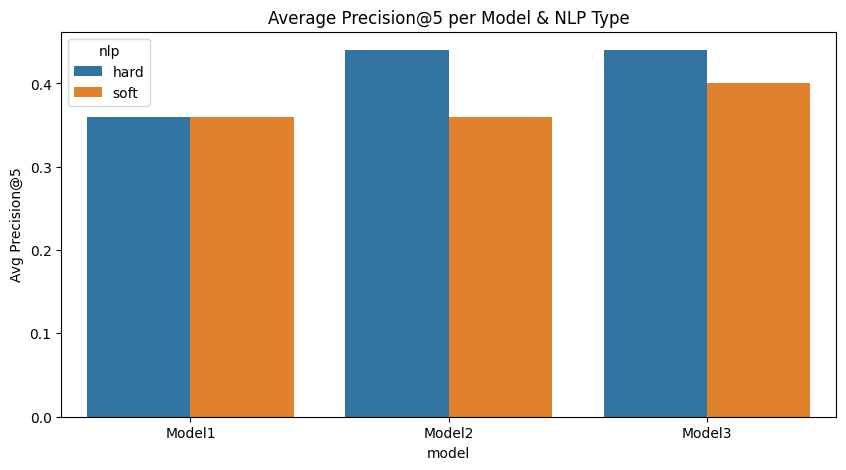

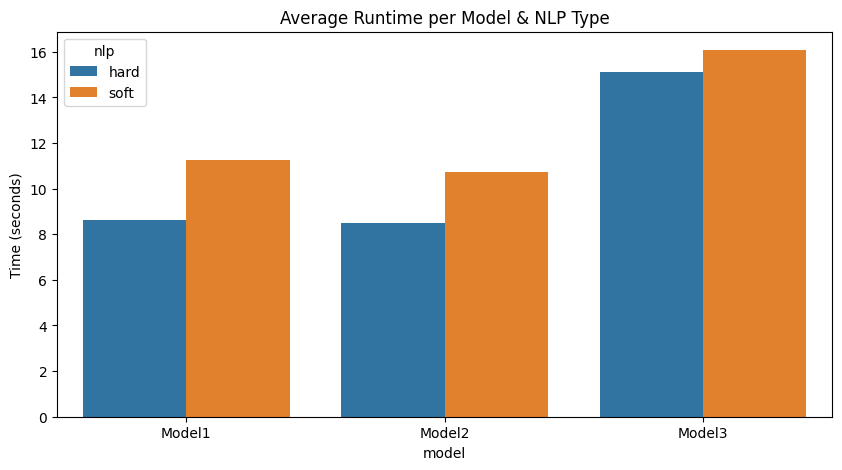

,student,model,nlp,precision@5
0,student1,Model1,soft,1.0
7,student2,Model2,soft,0.6
16,student3,Model2,hard,0.8
18,student4,Model1,soft,0.0
24,student5,Model1,soft,0.0


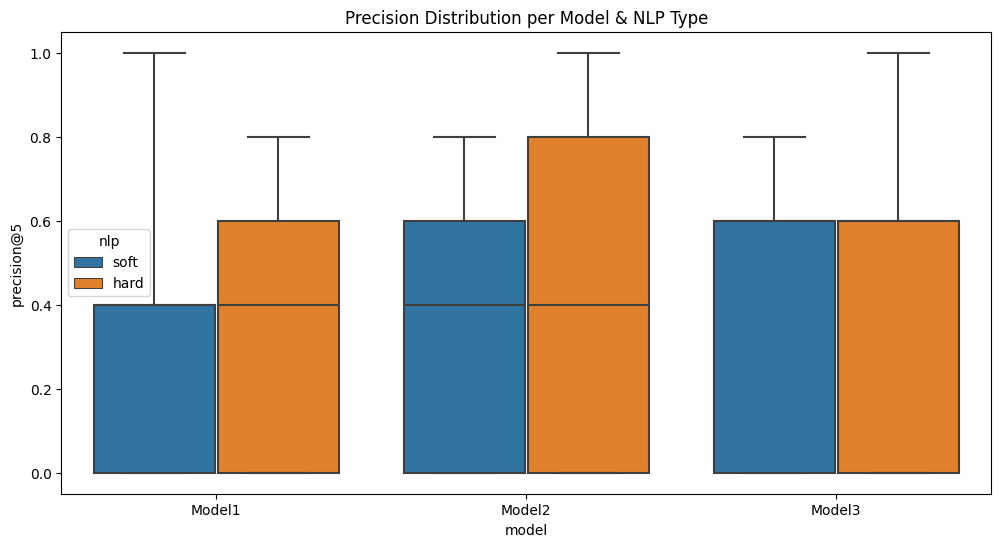

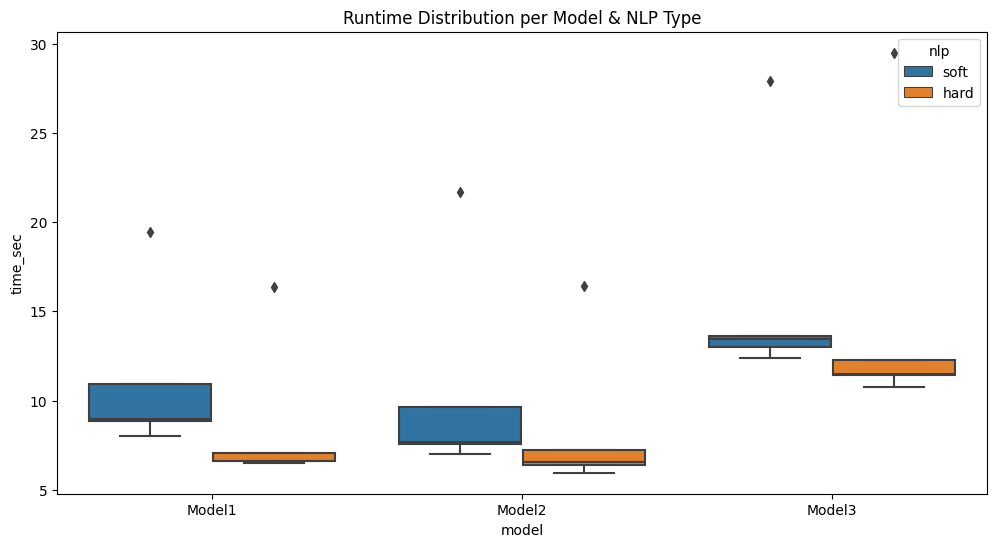

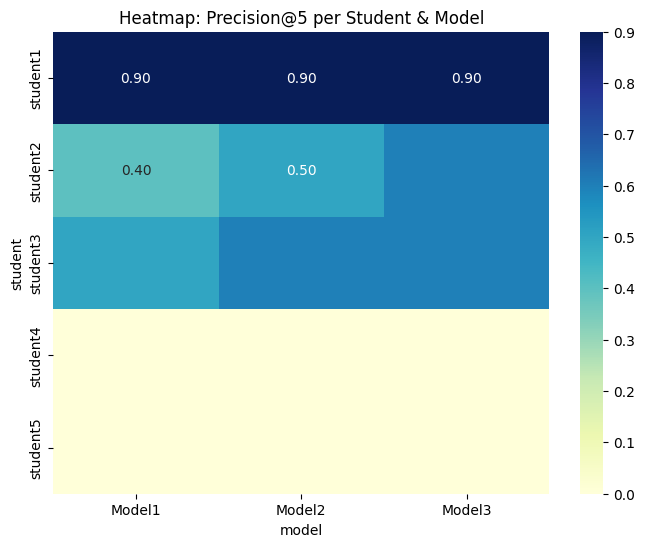

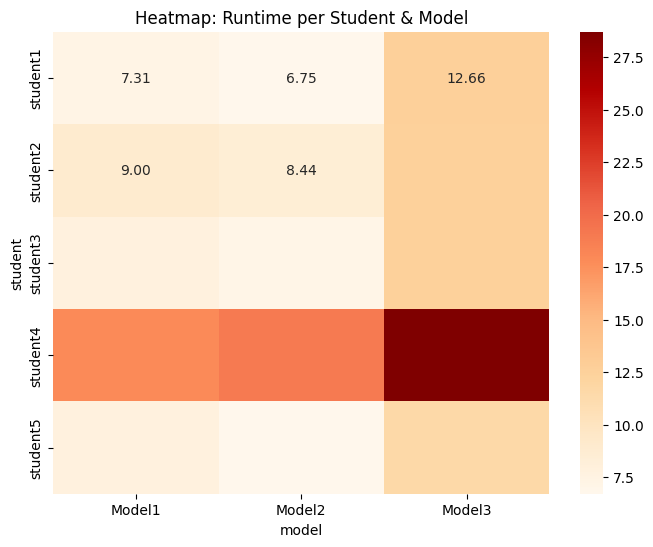

In [131]:
# Aggregate benchmark data into a DataFrame
benchmark_df = pd.DataFrame(benchmark_data)
display(benchmark_df.head())

# Average Precision per model and NLP type
avg_precision = benchmark_df.groupby(['model','nlp'])['precision@5'].mean().reset_index()
plt.figure(figsize=(10,5))
sns.barplot(data=avg_precision, x='model', y='precision@5', hue='nlp')
plt.title("Average Precision@5 per Model & NLP Type")
plt.ylabel("Avg Precision@5")
plt.show()

# Average runtime per model and NLP type
avg_time = benchmark_df.groupby(['model','nlp'])['time_sec'].mean().reset_index()
plt.figure(figsize=(10,5))
sns.barplot(data=avg_time, x='model', y='time_sec', hue='nlp')
plt.title("Average Runtime per Model & NLP Type")
plt.ylabel("Time (seconds)")
plt.show()

# Top model per student based on Precision
top_models = benchmark_df.loc[benchmark_df.groupby('student')['precision@5'].idxmax()]
display(top_models[['student','model','nlp','precision@5']])

# Precision distribution per model
plt.figure(figsize=(12,6))
sns.boxplot(data=benchmark_df, x='model', y='precision@5', hue='nlp')
plt.title("Precision Distribution per Model & NLP Type")
plt.show()

# Runtime distribution per model
plt.figure(figsize=(12,6))
sns.boxplot(data=benchmark_df, x='model', y='time_sec', hue='nlp')
plt.title("Runtime Distribution per Model & NLP Type")
plt.show()

# Heatmap of precision per student & model
pivot_prec = benchmark_df.pivot_table(index='student', columns='model', values='precision@5')
plt.figure(figsize=(8,6))
sns.heatmap(pivot_prec, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Heatmap: Precision@5 per Student & Model")
plt.show()

# Heatmap of runtime per student & model
pivot_time = benchmark_df.pivot_table(index='student', columns='model', values='time_sec')
plt.figure(figsize=(8,6))
sns.heatmap(pivot_time, annot=True, cmap="OrRd", fmt=".2f")
plt.title("Heatmap: Runtime per Student & Model")
plt.show()
